In [3]:
## Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import pylab
import imageio
import skimage.io
import numpy as np  
import cv2 as cv
from scipy import signal

In [15]:
# class includes necessary functions
class pulseSignalTracking():
    
    def __init__(self, video):
        self.video = video # original cideo
        self.cuttedVideo = None # cutted video
        self.frame1 = None # the first frame is used to coose points
        self.startPoint = None # the points we're going to track
        self.hasFindROI = False
        self.hasCutted = False
        self.hasChosenPoints = False
        if video:
            print("The fps of this video is", self.getFps()) 
        
    def getFps(self):
        cap = cv.VideoCapture(self.video)
        fps = cap.get(cv.CAP_PROP_FPS)
        return fps
    
    def findROI(self):
        # Find the ROI
        cap =cv.VideoCapture(self.video)
        #cap =cv.VideoCapture('wrist_white_cut_1.avi')
        ret,frame = cap.read()
        cv.namedWindow("Demo", cv.WINDOW_AUTOSIZE)
        # choosing ROI
        x, y, w, h = cv.selectROI("Demo", frame, True, False)
        track_window = (x, y, w, h)
        while True:
            k = cv.waitKey(60) & 0xff
            if k == 27:
                break
        cv.destroyAllWindows()
        cap.release()
        self.hasFindROI = True
        print("we have found ROI, next please cut it.")
        print("The width and height of ROI is ('w'=%d, 'h'=%d)" % (w,h)  )
        return x, y, w, h
    
    def cutROI(self):
        # first find the location of ROI
        x, y, w, h = self.findROI()
        # the cut ROI
        if not self.hasFindROI:
            print("Please find ROI first!")
            return
        cap = cv.VideoCapture(self.video)
        fps = cap.get(cv.CAP_PROP_FPS)
        #size = (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)),
        #        int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))
        fourcc = cv.VideoWriter_fourcc(*'XVID')
        out = cv.VideoWriter("out.avi",-1,self.getFps(),(w,h))
        
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret==True:
                frame = frame[y:y+h, x:x+w]
                # write the flipped frame
                out.write(frame)
                cv.imshow('frame',frame)
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
                
        self.hasCutted = True
        self.cuttedVideo = 'out.avi'
        # Release everything if job is finished
        cap.release()
        out.release()
        cv.destroyAllWindows()
        print("cut ROI finished!")
        
    def choosePoints(self):
        if not self.hasCutted:
            print("Please cut the video first!")
            return
        cap = cv.VideoCapture(self.cuttedVideo)
        ret, old_frame = cap.read()
        cv.imwrite("out_1st.png", old_frame)
        self.frame1 = "out_1st.png"
        img = cv.imread(self.frame1)
        history = []
        def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
            if event == cv.EVENT_LBUTTONDOWN:
                xy = "%d,%d" % (x, y)
                print (xy)
                history.append([x, y])
                cv.circle(img, (x, y), 1, (255, 0, 0), thickness = -1)
                cv.putText(img, xy, (x, y), cv.FONT_HERSHEY_PLAIN,
                    1.0, (0,0,0), thickness = 1)
                cv.imshow("image", img)

        cv.namedWindow("image")
        cv.setMouseCallback("image", on_EVENT_LBUTTONDOWN)
        cv.imshow("image", img)

        while(True):
            if cv.waitKey(0) & 0xFF == ord('q'):
                cv.destroyWindow("image")
                break
                
        self.startPoint = np.array(history, dtype='f').reshape(-1,1,2)
        self.hasChosenPoints = True
        print("has chosen the points")
        print(len(self.startPoint), " points have been chosen. Next track them.")
        
    
    def trackPoints(self):
        if not self.hasChosenPoints:
            print("Please find the points we want to track first!")
            return
        cap = cv.VideoCapture(self.cuttedVideo)
        size = (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)),
                int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)))
        out=cv.VideoWriter("OF_ohand_ut.avi",-1,self.getFps(),size)
          
        # Parameters for lucas kanade optical flow 
        lk_params = dict( winSize  = (25,25),
                         maxLevel = 5,
                         criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 6, 0.01))
        # Create some random colors
        color = np.random.randint(0,255,(100,3))

        # Take first frame and find corners in it
        ret, old_frame = cap.read()
        old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
        # do not change self.points, it is the starting point
        p0 = self.startPoint[:]
        # Create a mask image for drawing purposes
        mask = np.zeros_like(old_frame)

        num_frames = 0
        # self.records is used to record the motion of the points
        self.records = []
        while(1):
            ret,frame = cap.read()
            if not ret:
                break
            num_frames += 1
            frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

            # calculate optical flow
            #pl表示光流检测后的角点位置，st表示是否是运动的角点，err表示是否出错
            p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

            # Select good points
            good_new = p1[st==1]
            good_old = p0[st==1]
            self.records.append(good_new)
    
            # draw the tracks
            for i,(new,old) in enumerate(zip(good_new,good_old)):
                a,b = new.ravel()
                c,d = old.ravel()
                mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 3)
                frame = cv.circle(frame,(a,b),4,color[i].tolist(),-1)
            img = cv.add(frame,mask)

            cv.imshow('frame',img)
            k = cv.waitKey(30) & 0xff
            if k == 27:
                break

            # Now update the previous frame and previous points
            old_gray = frame_gray.copy()
            p0 = good_new.reshape(-1,1,2)
    
            out.write(frame)

        cv.destroyAllWindows()
        cap.release()
        print("has successfully detected and tracked the motions of points!")
        
        
    def trackWithoutRemoveGlobal(self, starting, points):
        # this function can only track single point
        num_points = len(starting)
        if num_points != 1:
            print("too many points!")
            return
        distance = []
        for i in range(len(points)-1):
            if i == 0:
                d = np.sqrt(np.sum((points[i] - starting)**2))
                distance.append(d)
            else:
                #d = np.sqrt(np.sum((points[i] - points[i-1])**2))
                d = np.sqrt(np.sum((points[i] - starting)**2))
                distance.append(d)
        print("has successfully transformed motions into signals!")
        return distance
        
    
    def trackWithRemoveGlobal(self, starting, points):
        # this function is to remove the golbal motion simply by taking the averaged motions of NON-ROI 
        # requirements: The first point is what you are interested in; The remaining are from the 
        num_points = len(starting)
        if num_points <= 2:
            print("not enough points!")
            return
    
        distance = []
        for i in range(len(points) - 1):
        
            # no ROI 
            deltas = []
            for j in range(1, num_points):
                deltas.append(points[i][j] - starting[j])
            delta = np.mean(deltas, axis=0)
            # ROI 
            temp = points[i][0] - delta - starting[0]
            distance.append( np.sqrt(np.sum(temp**2)) )
        print("has successfully transformed motions into signals!")
        return distance
    
    
    def transformIntoSignal(self):
        if not self.startPoint.any():
            print("currently we do not have chosen starting point(s).")
            return
        #self.distance = None
        # tracking without removing global motions
        if len(self.startPoint) == 1:
            print("Single point tracking (without removing global motions)")
            self.distance = self.trackWithoutRemoveGlobal(self.startPoint, self.records)
        # tracking with removing global motions
        else:
            print("Multiple points tracking (with removing global motions)")
            self.distance = self.trackWithRemoveGlobal(self.startPoint, self.records)


    def fda(self, x_1,Fstop1,Fstop2): #（输入的信号，截止频率下限，截止频率上限）
        fs = 30
        b, a = signal.butter(8, [2.0*Fstop1/fs,2.0*Fstop2/fs], 'bandpass')
        # print(b, a)
        w, h = signal.freqs(b, a)
        plt.semilogx(w, 20 * np.log10(abs(h)))
        plt.margins(0, 0.1)
        plt.show()
        filtedData = signal.filtfilt(b,a,x_1)
        return filtedData

    def filterSignal(self):
        if not self.distance:
            print("no distance records")
            return
        self.dis_filter = self.fda(self.distance,0.5, 6)
         
    def plotSignal(self):
        plt.plot(self.distance)
        plt.xlabel('Frames')
        plt.ylabel('Distance')
        plt.show()
        plt.plot(self.dis_filter)
        plt.rcParams['figure.figsize'] = (30.0, 5.0)
        plt.xlabel('Frames')
        plt.ylabel('Distance')
        plt.show()



### Single point tracking (without removing global motions)

In [16]:
video = 'wrist_white_20s-alpha50-sigma3-band8.000000e-01-1.800000e+00-refFrame200-withoutlarge.avi'
pst = pulseSignalTracking(video)
pst.cutROI()

The fps of this video is 30.0
we have found ROI, next please cut it.
The width and height of ROI is ('w'=402, 'h'=356)
cut ROI finished!


In [17]:
pst.choosePoints()

182,193
has chosen the points
1  points have been chosen. Next track them.


In [18]:
pst.trackPoints()

has successfully detected and tracked the motions of points!


In [19]:
pst.transformIntoSignal()

Single point tracking (without removing global motions)
has successfully transformed motions into signals!


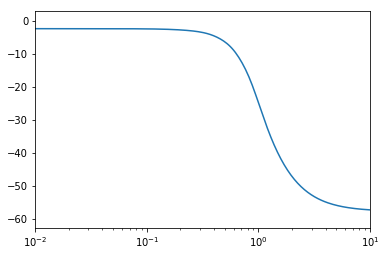

In [20]:
pst.filterSignal()

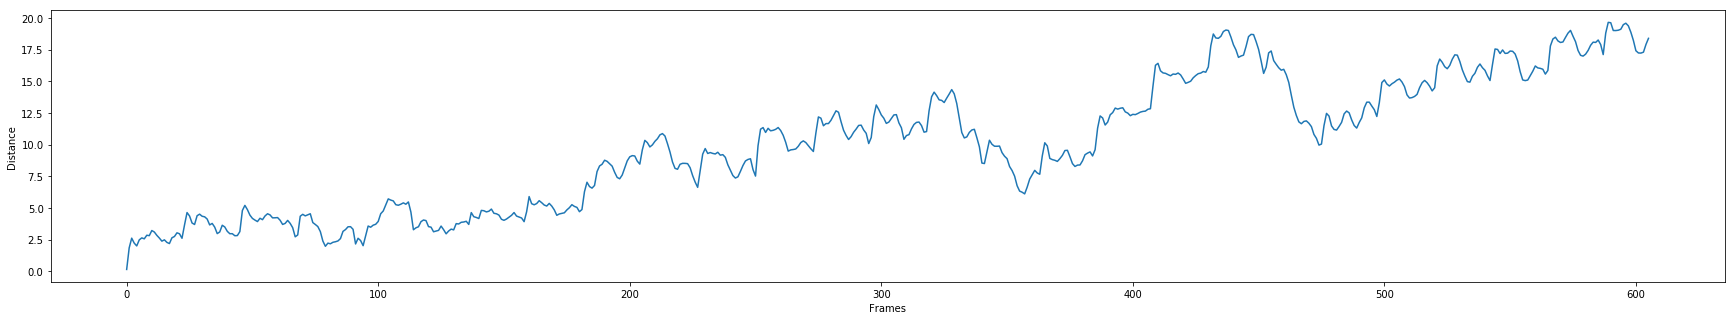

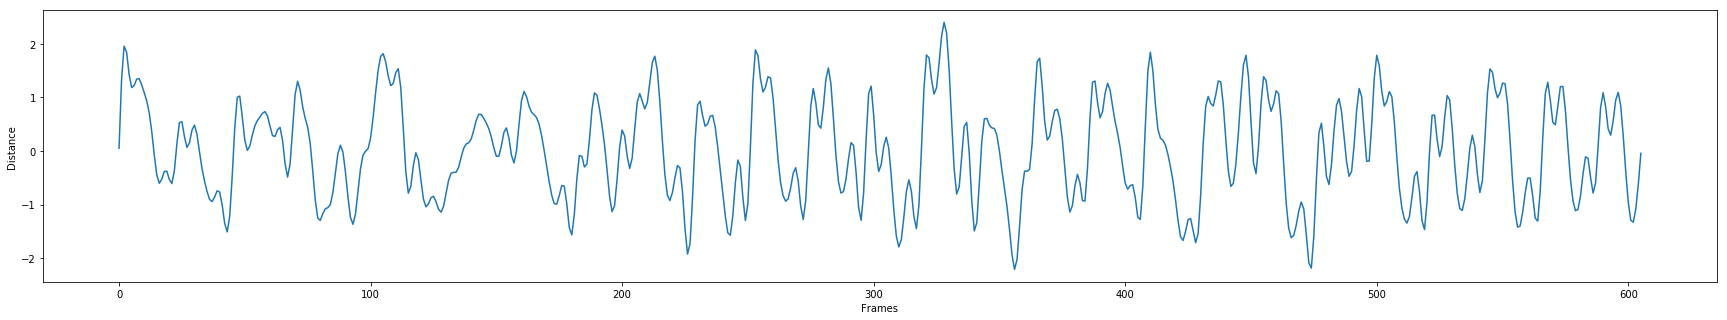

In [22]:
pst.plotSignal()

### Multiple points tracking (with removing global motions)

In [23]:
video = 'wrist_white_20s-alpha50-sigma3-band8.000000e-01-1.800000e+00-refFrame200-withoutlarge.avi'
pst = pulseSignalTracking(video)
pst.cutROI()

The fps of this video is 30.0
we have found ROI, next please cut it.
The width and height of ROI is ('w'=488, 'h'=348)
cut ROI finished!


In [24]:
pst.choosePoints()

232,184
354,75
105,65
76,268
has chosen the points
4  points have been chosen. Next track them.


In [25]:
pst.trackPoints()

has successfully detected and tracked the motions of points!


In [26]:
pst.transformIntoSignal()

Multiple points tracking (with removing global motions)
has successfully transformed motions into signals!


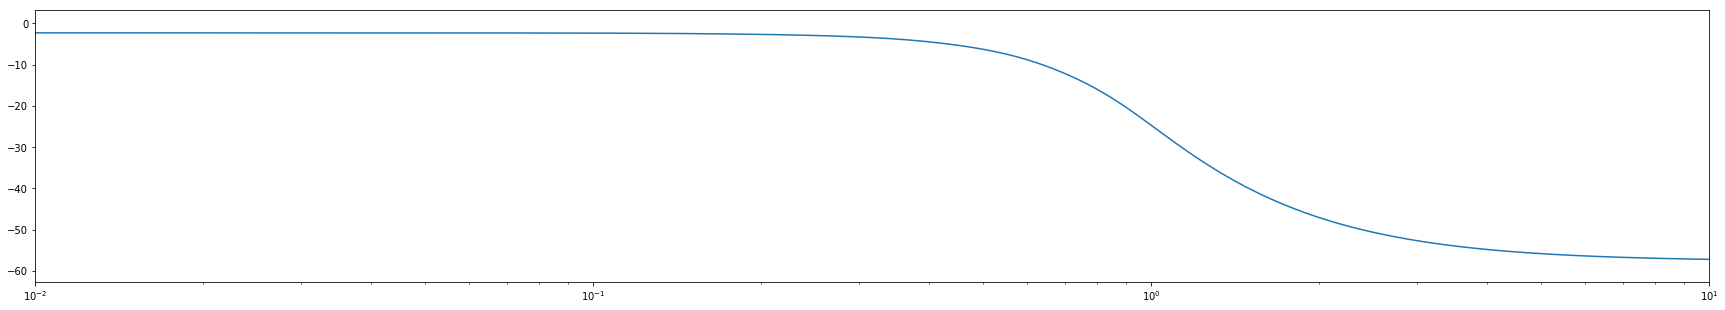

In [27]:
pst.filterSignal()

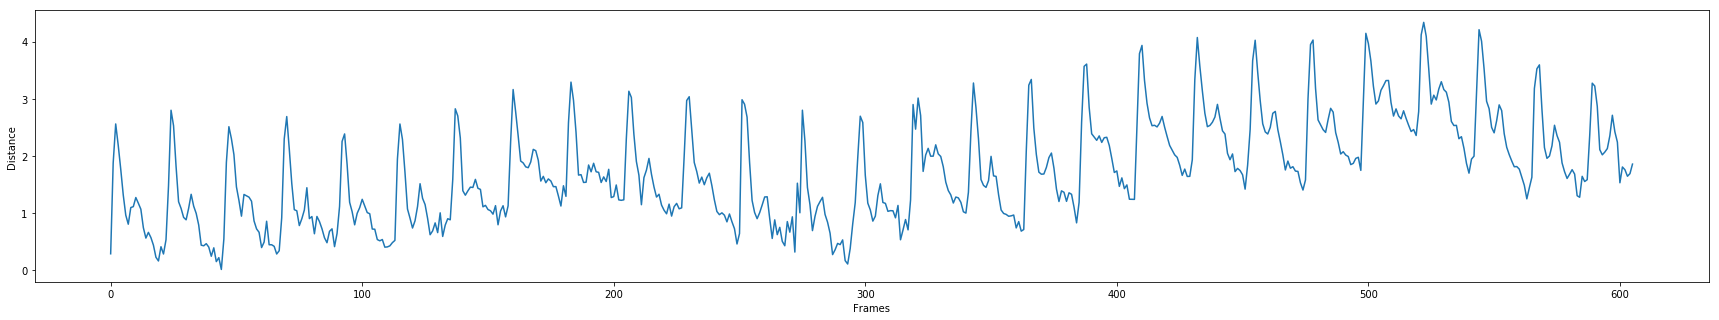

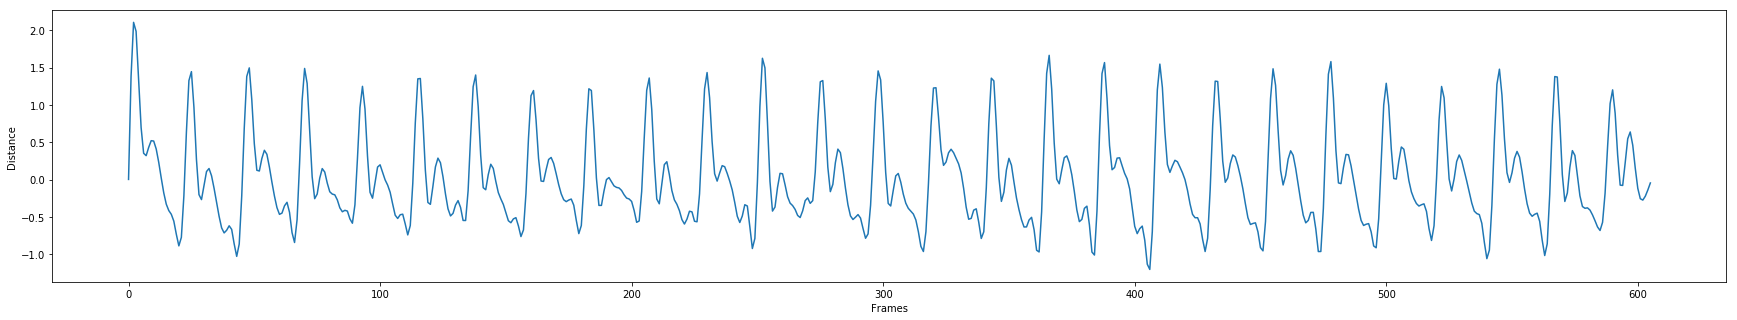

In [28]:
pst.plotSignal()